# Library Import

Pandas
Importing the data into a dataframe; for manipulations of the dataframe and easy plotting

Numpy
For vector and matrix calculations

Matplotlib
For plotting

Seaborn
For plotting

SKLearn
For the machine learning part

Scipy
For some statistics


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colorbar as mpl
import subprocess
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.tree import export_graphviz
from sklearn.externals import joblib
from scipy.stats import randint
from datetime import datetime

/Users/melanievollmar/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Data Import

In [2]:
data = pd.read_csv("data.csv", na_filter=False, skipinitialspace=True, thousands=',')
print(data.head())

   sweep_id  pdb_id_id  wavelength  MR_success  TFZ   LLG  PAK  mr_reso  \
0       144       1003      0.9797         0.0  5.8  33.0  5.0     1.38   
1       145       1003      0.9184         0.0  5.8  33.0  5.0     1.38   
2       146       1003      0.9792         0.0  5.8  33.0  5.0     1.38   
3       918        101      0.9793         0.0  4.1  17.0  1.0     1.66   
4       919        101      0.9537         0.0  4.1  17.0  1.0     1.66   

   mr_sg  mr_sg_no     ...       wilsonbfactor  RmeasI  highreslimit  \
0  P1211         4     ...               11.28  0.0723          1.38   
1  P1211         4     ...               11.30  0.0846          1.41   
2  P1211         4     ...               11.21  0.0879          1.39   
3     H3       146     ...               20.88  0.0910          1.66   
4     H3       146     ...               20.26  0.0937          1.67   

   RpimdiffI anomalousmulti  RmergediffI  totalobservations  anomalouscompl  \
0     0.0442           1.73       0.0

In [3]:
print(data.shape)

(673, 38)


# Isolate column names to use as features

In [4]:
column_names = data.columns
print(column_names)

Index(['sweep_id', 'pdb_id_id', 'wavelength', 'MR_success', 'TFZ', 'LLG',
       'PAK', 'mr_reso', 'mr_sg', 'mr_sg_no', 'RMSD', 'VRMS', 'eLLG', 'tncs',
       'model_pdb', 'seq_ident', 'model_res', 'anomalousCC', 'IoverSigma',
       'completeness', 'diffI', 'RmergeI', 'lowreslimit', 'RpimI',
       'multiplicity', 'RmeasdiffI', 'anomalousslope', 'diffF',
       'wilsonbfactor', 'RmeasI', 'highreslimit', 'RpimdiffI',
       'anomalousmulti', 'RmergediffI', 'totalobservations', 'anomalouscompl',
       'cchalf', 'totalunique'],
      dtype='object')


In [5]:
data_columns = data[['wavelength', 'mr_reso', 'mr_sg_no', 'eLLG', 'tncs',
       'model_res', 'anomalousCC', 'IoverSigma', 'completeness', 'diffI',
       'RmergeI', 'lowreslimit', 'RpimI', 'multiplicity', 'RmeasdiffI',
       'anomalousslope', 'diffF', 'wilsonbfactor', 'RmeasI', 'highreslimit',
       'RpimdiffI', 'anomalousmulti', 'RmergediffI', 'totalobservations',
       'anomalouscompl', 'cchalf', 'totalunique']]

data_columns_labels = data_columns.columns
print(data_columns_labels)
print(data_columns.shape)

Index(['wavelength', 'mr_reso', 'mr_sg_no', 'eLLG', 'tncs', 'model_res',
       'anomalousCC', 'IoverSigma', 'completeness', 'diffI', 'RmergeI',
       'lowreslimit', 'RpimI', 'multiplicity', 'RmeasdiffI', 'anomalousslope',
       'diffF', 'wilsonbfactor', 'RmeasI', 'highreslimit', 'RpimdiffI',
       'anomalousmulti', 'RmergediffI', 'totalobservations', 'anomalouscompl',
       'cchalf', 'totalunique'],
      dtype='object')


# Fill in missing values

In [6]:
data_columns_fill = data_columns.fillna(0)

# Data split - test and training set 

In [7]:
y = data['MR_success']

X_train, X_test, y_train, y_test = train_test_split(data_columns_fill, y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# Find best Decision tree with Bagging in RandomizedSearch

In [10]:
def rand_search(X_train, y_train):
  #create the decision tree 
  clf1 = DecisionTreeClassifier(random_state=0,
                                class_weight='balanced')#default base estimator decision tree
  #create bagging classifier
  tree_clf_rand_bag = BaggingClassifier(base_estimator=clf1,
                                        n_jobs=-1,
                                        bootstrap=True,
                                        random_state=100)

  #set up grid search
  param_rand = {'base_estimator__criterion': ['gini', 'entropy'],#metric to judge reduction of impurity
                'base_estimator__class_weight': ['balanced', None],
                'n_estimators': randint(100, 10000),#number of base estimators to use
                'base_estimator__max_features': randint(2, len(X_train.columns)),#max number of features when splitting
                'base_estimator__min_samples_split': randint(2, 20),#min samples per node to induce split
                'base_estimator__max_depth': randint(5, 10),#max number of splits to do
                'base_estimator__min_samples_leaf': randint(1, 20),#min number of samples in a leaf
                'base_estimator__max_leaf_nodes': randint(10, 20)}#max number of leaves

  #building and running the grid search
  rand_search = RandomizedSearchCV(tree_clf_rand_bag, param_rand, random_state=5, cv=3, n_iter=1,
                              scoring='accuracy', n_jobs=-1)
                              
  rand_search = rand_search.fit(X_train, y_train)
  print('Best parameters: ' +str(rand_search.best_params_)+'\n')
  print('Best score: ' +str(rand_search.best_score_)+'\n')
    
  best_params = rand_search.best_params_
  return best_params

rand_search(X_train, y_train)

Best parameters: {'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 5, 'base_estimator__max_features': 11, 'base_estimator__max_leaf_nodes': 18, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 9, 'n_estimators': 2082}

Best score: 0.773234200743



{'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 5,
 'base_estimator__max_features': 11,
 'base_estimator__max_leaf_nodes': 18,
 'base_estimator__min_samples_leaf': 5,
 'base_estimator__min_samples_split': 9,
 'n_estimators': 2082}

# Build best Decision Tree with Bagging, plot feature importances and get basic stats

Get various cross_val_scores to evaluate clf performance for best parameters 

Accuracy for each of 3 CV folds: [ 0.78888889  0.73184358  0.79888268] 

Mean accuracy over all 3 CV folds: 0.773205048624 

ROC_AUC mean for 3-fold CV: 0.845300109368 

Accuracy mean for 3-fold CV: 0.773205048624 

Recall mean for 3-fold CV: 0.621335064373 

Precision mean for 3-fold CV: 0.816835016835 

F1 score mean for 3-fold CV: 0.703179434523 



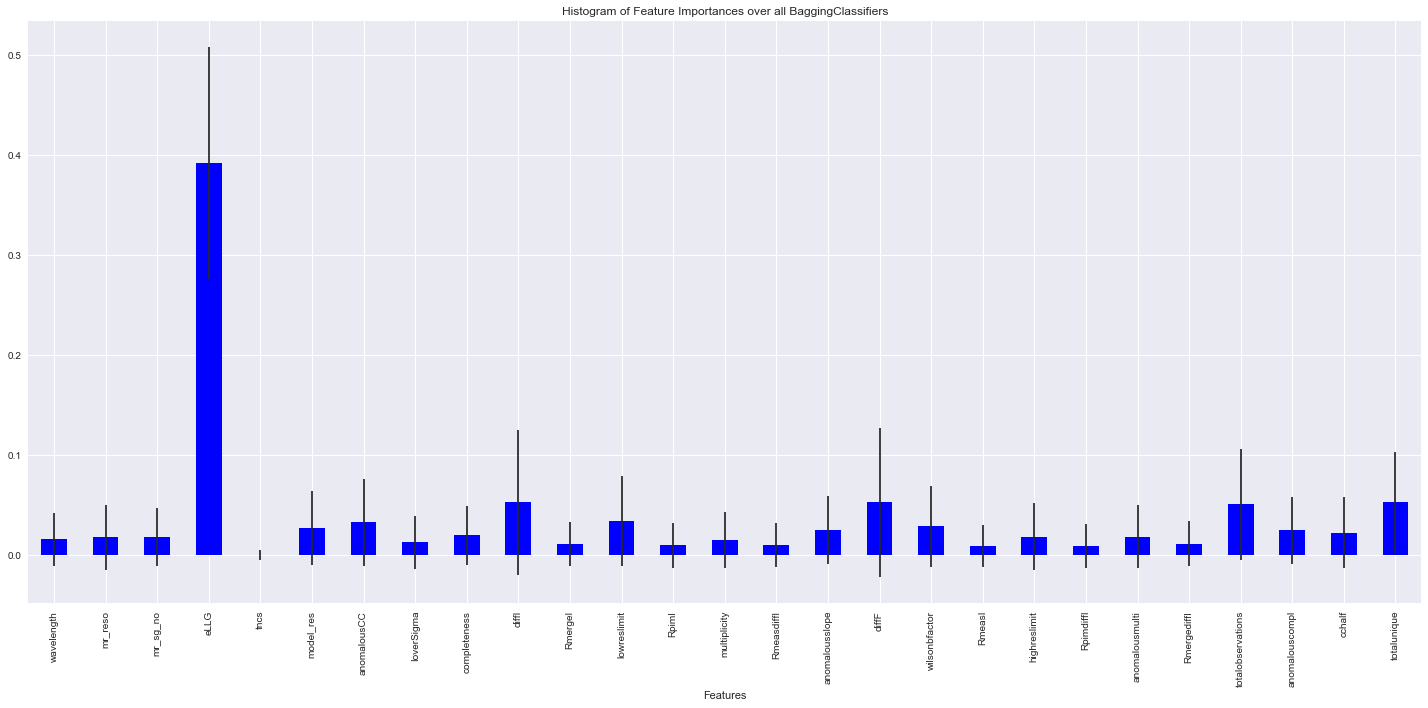

In [14]:
clf2 = DecisionTreeClassifier(class_weight = None,
                              criterion = 'gini',
                              max_depth = 5,
                              max_features = 11,
                              max_leaf_nodes = 18,
                              min_samples_leaf = 5,
                              min_samples_split = 9,
                              random_state= 0)

tree_clf_rand_bag_new = BaggingClassifier(clf2,
                                          n_estimators = 2082,
                                          n_jobs=-1,
                                          bootstrap=True,
                                          random_state=100)

tree_clf_rand_bag_new.fit(X_train, y_train)

def feature_importances_pandas(clf, X_train):   
  datestring = datetime.strftime(datetime.now(), '%Y%m%d_%H%M')      
  feature_list = []
  for tree in clf.estimators_:
    feature_importances_ls = tree.feature_importances_
    feature_list.append(feature_importances_ls)
        
  df = pd.DataFrame(feature_list, columns=X_train.columns)
  df_mean = df[X_train.columns].mean(axis=0)
  df_mean.sort_values(ascending=False, inplace=True)  
  df_std = df[X_train.columns].std(axis=0)
  df_mean.plot(kind='bar', color='b', yerr=[df_std], align="center", figsize=(20,10), rot=90, fontsize=16)
  plt.title('Histogram of Feature Importances for Bagging Classifier')
  plt.xlabel('Features')
  plt.tight_layout()
  plt.show
      
feature_importances_pandas(tree_clf_rand_bag_new, X_train)
   
def write_pickle(clf):
  datestring = datetime.strftime(datetime.now(), '%Y%m%d_%H%M')
  joblib.dump(clf, 'best_tree_rand_'+datestring+'.pkl')
    
write_pickle(tree_clf_rand_bag_new)
    
def visualise_tree(tree_bag, columns):
  datestring = datetime.strftime(datetime.now(), '%Y%m%d_%H%M')
  trees = tree_bag.estimators_
  i_tree = 0
  for tree in trees:
    with open('tree_clf_rand_bag_new_'+datestring+str(i_tree)+'.dot', 'w') as f:
      export_graphviz(tree, out_file=f, feature_names=columns, rounded=True, filled=True)
      f.close()
    dotfile = 'tree_clf_rand_bag_new_'+datestring+str(i_tree)+'.dot'
    pngfile = 'tree_clf_rand_bag_new_'+datestring+str(i_tree)+'.png'
    command = ["dot", "-Tpng", dotfile, "-o", pngfile]
    subprocess.check_call(command)
    i_tree = i_tree + 1

visualise_tree(tree_clf_rand_bag_new, X_train.columns)

def basic_stats(clf, X_train, y_train):
  #distribution --> accuracy
  accuracy_each_cv = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
  accuracy_mean_cv = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy').mean()
  # calculate cross_val_scoring with different scoring functions for CV train set
  train_roc_auc = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc').mean()
  train_accuracy = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy').mean()
  train_recall = cross_val_score(clf, X_train, y_train, cv=3, scoring='recall').mean()
  train_precision = cross_val_score(clf, X_train, y_train, cv=3, scoring='precision').mean()
  train_f1 = cross_val_score(clf, X_train, y_train, cv=3, scoring='f1').mean()

  print('Get various cross_val_scores to evaluate clf performance for best parameters \n')     
  print('Accuracy for each of 3 CV folds: %s \n' %accuracy_each_cv)
  print('Mean accuracy over all 3 CV folds: %s \n' %accuracy_mean_cv)
  print('ROC_AUC mean for 3-fold CV: %s \n' %train_roc_auc)
  print('Accuracy mean for 3-fold CV: %s \n' %train_accuracy)
  print('Recall mean for 3-fold CV: %s \n' %train_recall)
  print('Precision mean for 3-fold CV: %s \n' %train_precision)
  print('F1 score mean for 3-fold CV: %s \n' %train_f1)
    
basic_stats(tree_clf_rand_bag_new, X_train, y_train)


# Predict using the test set on Decision Tree with Bagging

In [15]:
def predict(clf, X_test):
  #try out how well the classifier works to predict from the test set
  y_pred = tree_clf_rand_bag_new.predict(X_test)
  y_pred_proba = tree_clf_rand_bag_new.predict_proba(X_test)

  def prediction_stats(y_test, y_pred):
    # calculate accuracy
    y_accuracy = metrics.accuracy_score(y_test, y_pred)

    # examine the class distribution of the testing set (using a Pandas Series method)
    class_dist = y_test.value_counts()

    # calculate the percentage of ones
    # because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
    ones = y_test.mean()

    # calculate the percentage of zeros
    zeros = 1 - y_test.mean()

    # calculate null accuracy in a single line of code
    # only for binary classification problems coded as 0/1
    null_acc = max(y_test.mean(), 1 - y_test.mean())

    print('Accuracy score or agreement between y_test and y_pred_class: %s \n' %y_accuracy)
    print('Class distribution for y_test: %s \n' %class_dist)
    print('Percent 1s in y_test: %s \n' %ones)
    print('Percent 0s in y_test: %s \n' %zeros)
    print('Null accuracy in y_test: %s \n' %null_acc)
    
  prediction_stats(y_test, y_pred)
  
  return y_pred, y_pred_proba

predict(tree_clf_rand_bag_new, X_test)

Accuracy score or agreement between y_test and y_pred_class: 0.8 

Class distribution for y_test: 0.0    76
1.0    59
Name: MR_success, dtype: int64 

Percent 1s in y_test: 0.43703703703703706 

Percent 0s in y_test: 0.5629629629629629 

Null accuracy in y_test: 0.5629629629629629 



(array([ 0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  1.]), array([[ 0.76613426,  0.23386574],
        [ 0.76110641,  0.23889359],
        [ 0.28168471,  0.71831529],
        [ 0.37078314,  0.62921686],
        [ 0.06713804,  0.93286196],
        [ 0.36169482,  0.63830518],
        [ 0.67264965

# Detailed analysis for Decision Tree with Bagging

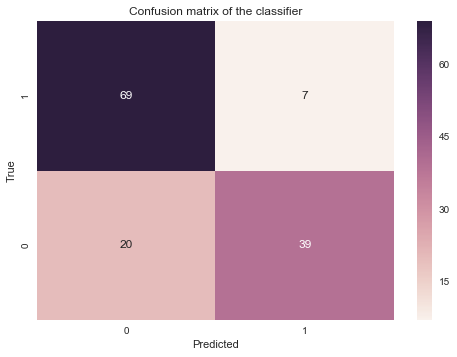

confusion matrix using test set: [[69  7]
 [20 39]] 

accuracy score manual test: 0.8 

accuracy score sklearn test: 0.8 

classification error manual test: 0.2 

classification error sklearn test: 0.2 

sensitivity manual test: 0.661016949153 

sensitivity sklearn test: 0.661016949153 

specificity manual test: 0.907894736842 

false positive rate manual test: 0.0921052631579 

1 - specificity test: 0.0921052631579 

precision manual: 0.847826086957 

precision sklearn: 0.847826086957 

F1 score sklearn test: 0.742857142857 



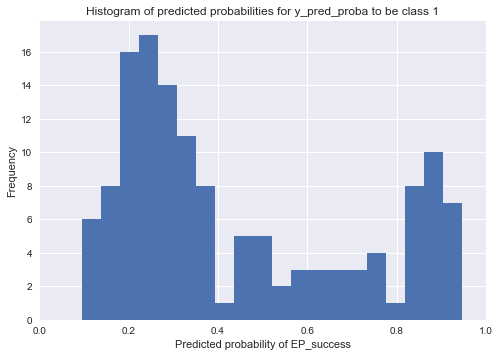

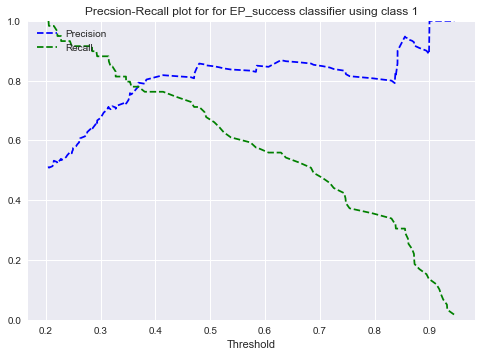

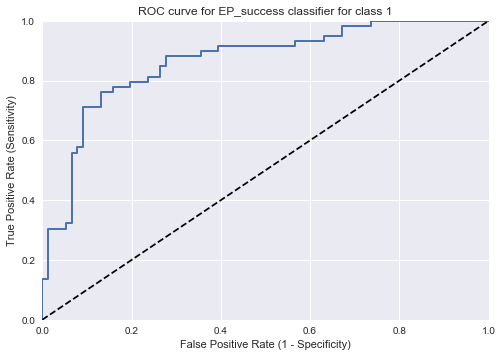

AUC for CV test set class 1: 0.864183764496 



In [16]:
def analysis(clf, X_train, y_train, X_test, y_test):
    #try out how well the classifier works to predict from the test set
  y_pred = clf.predict(X_test)
  y_pred_proba = clf.predict_proba(X_test)

  def conf_mat(y_test, y_pred):
    # IMPORTANT: first argument is true values, second argument is predicted values
    # this produces a 2x2 numpy array (matrix)
    conf_mat_test = metrics.confusion_matrix(y_test, y_pred)
    def draw_conf_mat(matrix):
      labels = ['0', '1']      
      ax = plt.subplot()
      sns.heatmap(matrix, annot=True, ax=ax)
      plt.title('Confusion matrix of the classifier')
      ax.set_xticklabels(labels)
      ax.set_yticklabels(labels)
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.show()

    draw_conf_mat(conf_mat_test)
      
    TP = conf_mat_test[1, 1]
    TN = conf_mat_test[0, 0]
    FP = conf_mat_test[0, 1]
    FN = conf_mat_test[1, 0]

    print('confusion matrix using test set: %s \n' %conf_mat_test)
      
    #calculate accuracy
    acc_score_man_test = (TP + TN) / float(TP + TN + FP + FN)
    acc_score_sklearn_test = metrics.accuracy_score(y_test, y_pred)
    print('accuracy score manual test: %s \n' %acc_score_man_test)
    print('accuracy score sklearn test: %s \n' %acc_score_sklearn_test)
        
    #classification error
    class_err_man_test = (FP + FN) / float(TP + TN + FP + FN)
    class_err_sklearn_test = 1 - metrics.accuracy_score(y_test, y_pred)
    print('classification error manual test: %s \n' %class_err_man_test)
    print('classification error sklearn test: %s \n' %class_err_sklearn_test)
        
    #sensitivity/recall/true positive rate; correctly placed positive cases  
    sensitivity_man_test = TP / float(FN + TP)
    sensitivity_sklearn_test = metrics.recall_score(y_test, y_pred)
    print('sensitivity manual test: %s \n' %sensitivity_man_test)
    print('sensitivity sklearn test: %s \n' %sensitivity_sklearn_test)
      
    #specificity  
    specificity_man_test = TN / (TN + FP)
    print('specificity manual test: %s \n' %specificity_man_test)
      
    #false positive rate  
    false_positive_rate_man_test = FP / float(TN + FP)
    print('false positive rate manual test: %s \n' %false_positive_rate_man_test)
    print('1 - specificity test: %s \n' %(1 - specificity_man_test))
      
    #precision/confidence of placement  
    precision_man_test = TP / float(TP + FP)
    precision_sklearn_test = metrics.precision_score(y_test, y_pred)
    print('precision manual: %s \n' %precision_man_test)
    print('precision sklearn: %s \n' %precision_sklearn_test)
      
    #F1 score; uses precision and recall  
    f1_score_sklearn_test = f1_score(y_test, y_pred)
    print('F1 score sklearn test: %s \n' %f1_score_sklearn_test)
        
  conf_mat(y_test, y_pred)

  def prediction_probas(clf, X_train, y_train, X_test, y_test, y_pred_proba): 
    #plot histograms of probabilities  
    def plot_hist_pred_proba(y_pred_proba):
      plt.hist(y_pred_proba, bins=20)
      plt.xlim(0,1)
      plt.title('Histogram of predicted probabilities for y_pred_proba to be class 1')
      plt.xlabel('Predicted probability of EP_success')
      plt.ylabel('Frequency')
      plt.show()
        
    plot_hist_pred_proba(y_pred_proba[:, 1])

    y_scores_ones = y_pred_proba[:, 1]#test data to be class 1
      
    #plot precision and recall curve
    def plot_precision_recall_vs_threshold(precisions, recalls, thresholds_tree):
      plt.plot(thresholds_tree, precisions[:-1], "b--", label="Precision")
      plt.plot(thresholds_tree, recalls[:-1], "g--", label="Recall")
      plt.title('Precsion-Recall plot for for EP_success classifier using class 1')
      plt.xlabel("Threshold")
      plt.legend(loc="upper left")
      plt.ylim([0,1])
      plt.show()

    #plot Precision Recall Threshold curve for test set        
    precisions, recalls, thresholds_tree = precision_recall_curve(y_test, y_scores_ones)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds_tree)

    #IMPORTANT: first argument is true values, second argument is predicted probabilities
    #we pass y_test and y_pred_prob
    #we do not use y_pred_class, because it will give incorrect results without generating an error
    #roc_curve returns 3 objects fpr, tpr, thresholds
    #fpr: false positive rate
    #tpr: true positive rate

    #plot ROC curves
    def plot_roc_curve(fpr, tpr):
      plt.plot(fpr, tpr, linewidth=2)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.axis([0, 1, 0, 1])
      plt.title('ROC curve for EP_success classifier for class 1' ) 
      plt.xlabel('False Positive Rate (1 - Specificity)')
      plt.ylabel('True Positive Rate (Sensitivity)')
      plt.grid(True)
      plt.show()
        
    #ROC curve for test set      
    fpr, tpr, thresholds = roc_curve(y_test, y_scores_ones)
    plot_roc_curve(fpr, tpr)
      
    #calculate the area under the curve to get the performance for a classifier
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    AUC_test_class1 = metrics.roc_auc_score(y_test, y_scores_ones)

    print('AUC for test set class 1: %s \n' %AUC_test_class1)

  prediction_probas(clf, X_train, y_train, X_test, y_test, y_pred_proba)    

analysis(tree_clf_rand_bag_new, X_train, y_train, X_test, y_test)